In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

%matplotlib inline

In [2]:
df = pd.read_csv("data/Fraud.csv")

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [6]:
df.shape

(6362620, 11)

In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
pd.set_option("display.float_format", "{:.2f}".format)

In [10]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [11]:
df.describe(include="object")

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1530544995,C1286084959
freq,2237500,3,113


In [12]:
df["type"].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [13]:
sdf = df[["type", "isFraud", "isFlaggedFraud"]].copy()
sdf["isFraud"] = sdf["isFraud"].astype(object)
sdf["isFlaggedFraud"] = sdf["isFlaggedFraud"].astype(object)

sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   type            object
 1   isFraud         object
 2   isFlaggedFraud  object
dtypes: object(3)
memory usage: 145.6+ MB


In [14]:
sdf.groupby("type").describe(include="all")

isFraud                     isFlaggedFraud                    
            count unique top     freq          count unique top     freq
type                                                                    
CASH_IN   1399284      1   0  1399284        1399284      1   0  1399284
CASH_OUT  2237500      2   0  2233384        2237500      1   0  2237500
DEBIT       41432      1   0    41432          41432      1   0    41432
PAYMENT   2151495      1   0  2151495        2151495      1   0  2151495
TRANSFER   532909      2   0   528812         532909      2   0   532893

In [15]:
from scipy.stats import chi2_contingency

contingency_nameOrig = pd.crosstab(df["nameOrig"], df["isFraud"])
contingency_nameDest = pd.crosstab(df["nameDest"], df["isFraud"])

In [16]:
statistic, p_value, dof, expected = chi2_contingency(contingency_nameOrig)

if p_value <= 0.05:
    print("Reject the null hypothesis: There is a significant association between nameOrig and isFraud.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between nameOrig and isFraud.")

Fail to reject the null hypothesis: There is no significant association between nameOrig and isFraud.


In [17]:
statistic, p_value, dof, expected = chi2_contingency(contingency_nameDest)

if p_value <= 0.05:
    print("Reject the null hypothesis: There is a significant association between nameDest and isFraud.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between nameDest and isFraud.")

Reject the null hypothesis: There is a significant association between nameDest and isFraud.


In [18]:
df.drop("nameOrig", axis=1, inplace=True)

In [19]:
nameDest_val_counts = df["nameDest"].value_counts()
frequent_vals = nameDest_val_counts[nameDest_val_counts > 1].index
df["dest_group"] = df["nameDest"].where(df["nameDest"].isin(frequent_vals), "other")
len(df["dest_group"].unique())

459659

In [20]:
df.drop("nameDest", axis=1, inplace=True)

In [21]:
sdf["dest_group"] = df["dest_group"].astype(object)
sdf.head()

,type,isFraud,isFlaggedFraud,dest_group
0,PAYMENT,0,0,other
1,PAYMENT,0,0,other
2,TRANSFER,1,0,C553264065
3,CASH_OUT,1,0,C38997010
4,PAYMENT,0,0,other


In [22]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,dest_group
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0,other
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0,other
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,C553264065
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,C38997010
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0,other


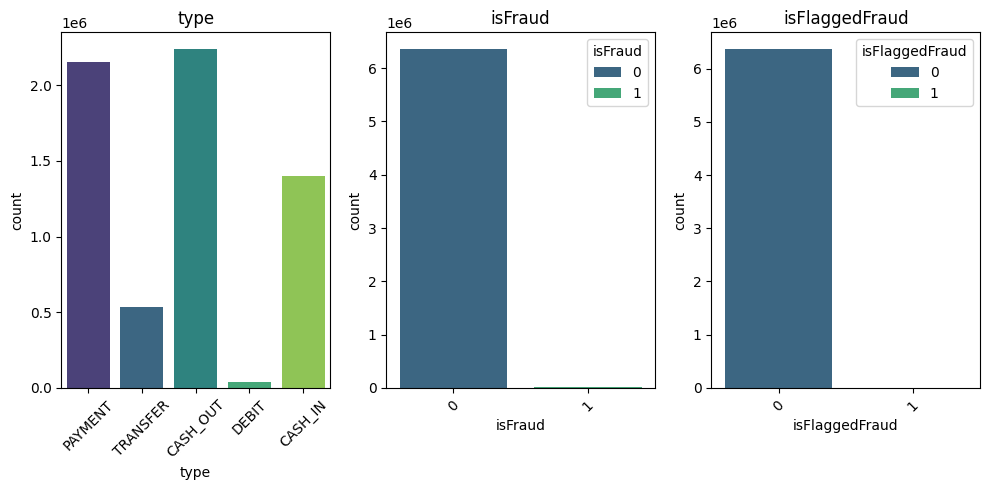

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for i, col in enumerate(["type", "isFraud", "isFlaggedFraud"]):
    sns.countplot(x=col, hue=col, data=sdf, ax=axes[i], palette="viridis")
    axes[i].set_title(col)
    axes[i].tick_params(axis="x", labelrotation=45)

plt.tight_layout()

In [24]:
numerical_vals = df.select_dtypes(include=["int32", "int64", "float64"]).columns.tolist()

num_vals_stats = [val for val in numerical_vals if val not in {"isFraud", "isFlaggedFraud"}]

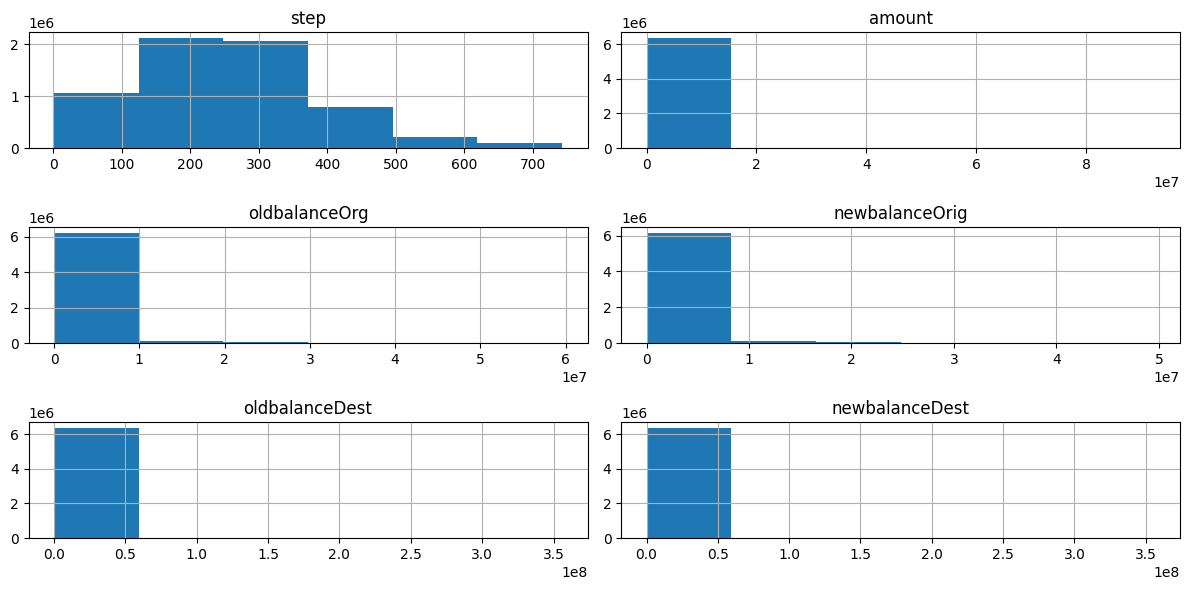

In [25]:
df[num_vals_stats].hist(figsize=(12, 6), layout=(3, 2), bins=6)
plt.tight_layout()

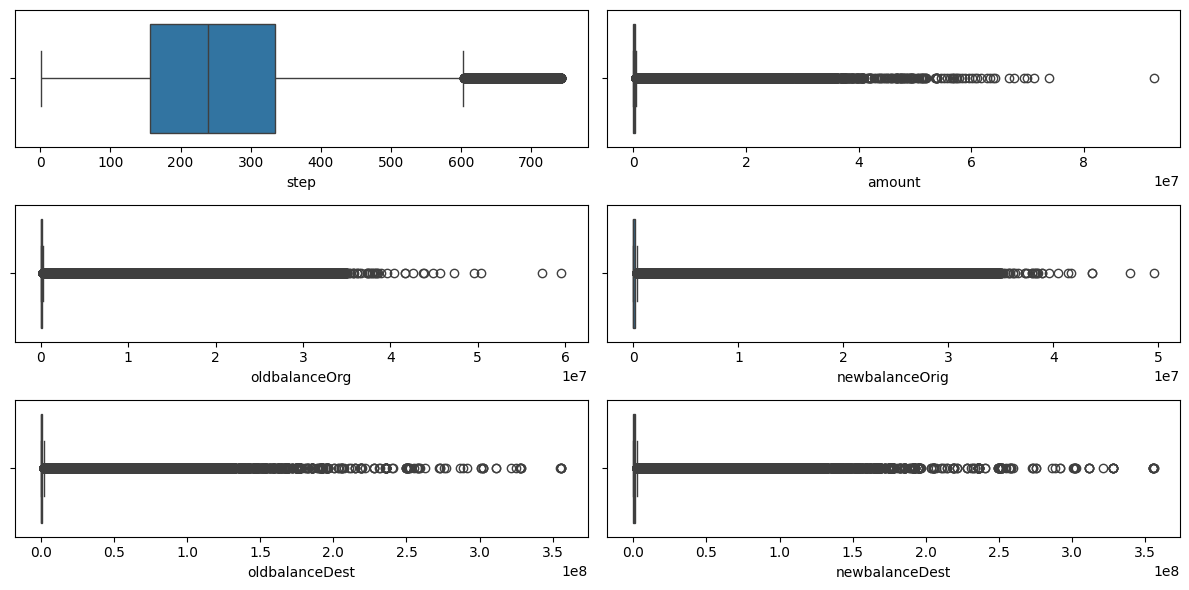

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

for i, col in enumerate(num_vals_stats):
    sns.boxplot(data=df, x=col, ax=axes.flat[i])

plt.tight_layout()


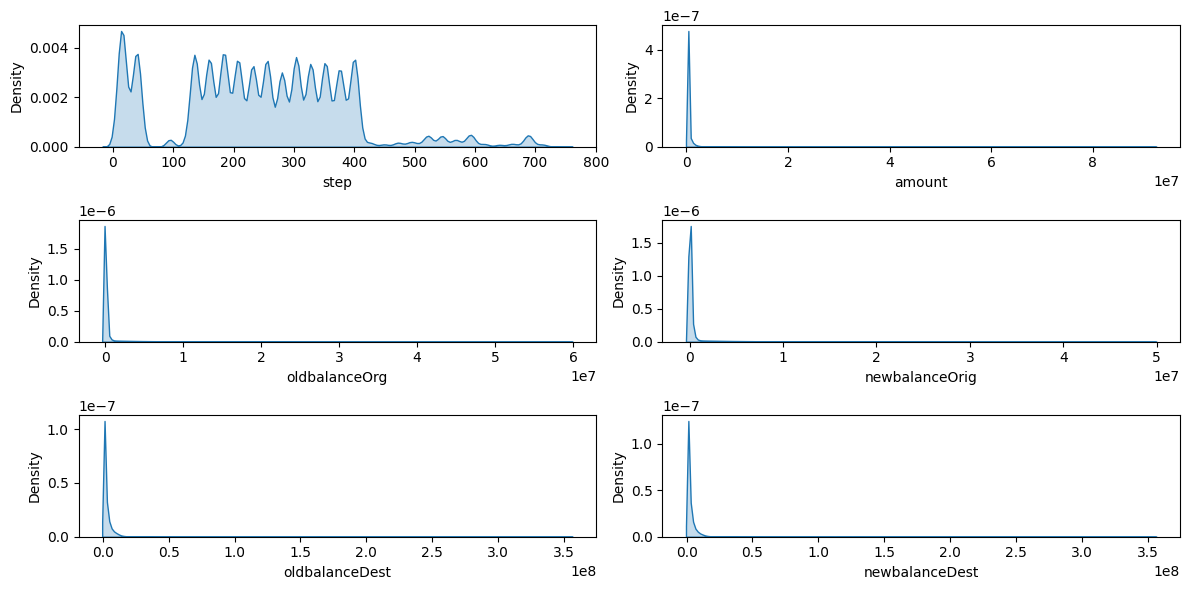

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

for i, col in enumerate(num_vals_stats):
    sns.kdeplot(data=df, x=col, ax=axes.flat[i], fill=True)
    
plt.tight_layout()

Text(0.5, 1.0, 'Correlation Matrix of Numerical Features')

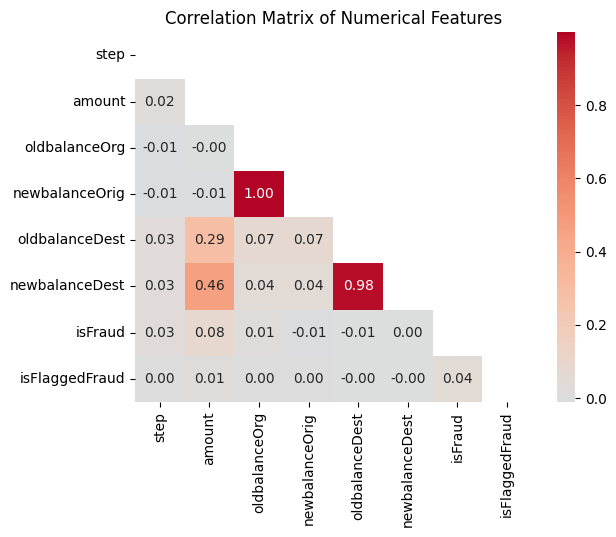

In [28]:
corr = df[numerical_vals].corr()
matrix = np.triu(corr)

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, mask=matrix)
plt.title("Correlation Matrix of Numerical Features")

In [29]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 4 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   type            object
 1   isFraud         object
 2   isFlaggedFraud  object
 3   dest_group      object
dtypes: object(4)
memory usage: 194.2+ MB


In [30]:
contingency_type = pd.crosstab(sdf["type"], sdf["isFraud"])

statistic, p_value, dof, expected = chi2_contingency(contingency_type)

if p_value <= 0.05:
    print("Reject the null hypothesis: There is a significant association between type and isFraud.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between type and isFraud.")

Reject the null hypothesis: There is a significant association between type and isFraud.


In [31]:
types = pd.get_dummies(data=sdf["type"], prefix="type", dtype="int32")

types.head()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0


In [32]:
sdf = pd.concat([sdf, types], axis=1)

sdf.drop("type", axis=1, inplace=True)
sdf.head()

,isFraud,isFlaggedFraud,dest_group,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,other,0,0,0,1,0
1,0,0,other,0,0,0,1,0
2,1,0,C553264065,0,0,0,0,1
3,1,0,C38997010,0,1,0,0,0
4,0,0,other,0,0,0,1,0


Text(0.5, 1.0, 'Correlation Matrix of Categorical Features')

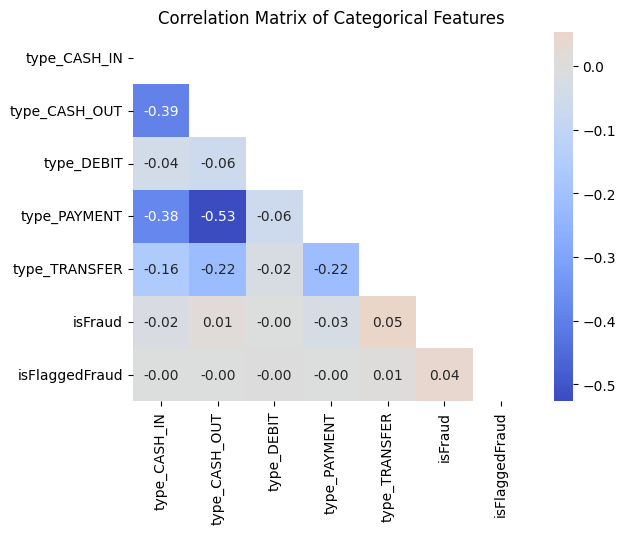

In [33]:
corr = sdf[types.columns.to_list() + ["isFraud", "isFlaggedFraud"]].corr()
matrix = np.triu(corr)

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, mask=matrix)
plt.title("Correlation Matrix of Categorical Features")

In [34]:
df.groupby(by=["isFraud", "type"])["amount"].count()

isFraud  type    
0        CASH_IN     1399284
         CASH_OUT    2233384
         DEBIT         41432
         PAYMENT     2151495
         TRANSFER     528812
1        CASH_OUT       4116
         TRANSFER       4097
Name: amount, dtype: int64

In [35]:
df.groupby("isFraud")["amount"].count()

isFraud
0    6354407
1       8213
Name: amount, dtype: int64

In [83]:
y = df["isFraud"]
X = df.drop(columns=["isFraud", "isFlaggedFraud"])

In [84]:
X["type"] = X["type"].replace({"PAYMENT": "other", "CASH_IN": "other", "DEBIT": "other"}).astype("category")
X["dest_group"] = X["dest_group"].astype("category")

In [85]:
y.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [86]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [88]:
numerical_vars = X_train.select_dtypes(include="number").columns.tolist()

In [89]:
preprocess = ColumnTransformer(
    transformers=[
        ("numerical_vars", StandardScaler(), numerical_vars),
        ("categorical_vars_type", OneHotEncoder(handle_unknown="ignore"), ["type"]),
        ("categorical_vars_dest_group", TargetEncoder(), ["dest_group"]),
    ],
    remainder="passthrough",
)

In [90]:
preprocess

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical_vars', StandardScaler(),
                                 ['step', 'amount', 'oldbalanceOrg',
                                  'newbalanceOrig', 'oldbalanceDest',
                                  'newbalanceDest']),
                                ('categorical_vars_type',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['type']),
                                ('categorical_vars_dest_group', TargetEncoder(),
                                 ['dest_group'])])

In [91]:
X_train_transformed = preprocess.fit_transform(X_train, y_train)

In [92]:
feature_names = preprocess.get_feature_names_out()

In [93]:
space = {
    "max_depth": hp.quniform("max_depth", 3, 18, 1),
    "gamma": hp.uniform("gamma", 1, 9),
    "reg_alpha": hp.uniform("reg_alpha", 40, 180),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
    "n_estimators": 180,
    "seed": 0
}

In [94]:
X_test_transformed = preprocess.transform(X_test)

In [ ]:
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

def objective(space):
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        booster="gbtree",
        tree_method="hist",
        scale_pos_weight=scale_pos_weight,
        eval_metric="aucpr",
        use_label_encoder=False,
        random_state=42,
        n_estimators=space["n_estimators"],
        learning_rate=0.1,
        max_depth=int(space["max_depth"]),
        gamma=space["gamma"],
        reg_alpha=space["reg_alpha"],
        reg_lambda=space["reg_lambda"],
        colsample_bytree=space["colsample_bytree"],
        min_child_weight=int(space["min_child_weight"])
    )

    model.fit(X_train_transformed, y_train, eval_set=[(X_test_transformed, y_test)], verbose=True)
    y_pred = model.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")

    return {'loss': log_loss(y_test, y_pred), 'status': STATUS_OK }

In [97]:
trials = Trials()

best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:38:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.51556                         
[1]	validation_0-aucpr:0.66132                         
[2]	validation_0-aucpr:0.70311                         
[3]	validation_0-aucpr:0.80757                         
[4]	validation_0-aucpr:0.81370                         
[5]	validation_0-aucpr:0.78078                         
[6]	validation_0-aucpr:0.81057                         
[7]	validation_0-aucpr:0.83995                         
[8]	validation_0-aucpr:0.83758                         
[9]	validation_0-aucpr:0.84926                         
[10]	validation_0-aucpr:0.86907                        
[11]	validation_0-aucpr:0.87337                        
[12]	validation_0-aucpr:0.87172                        
[13]	validation_0-aucpr:0.87415                        
[14]	validation_0-aucpr:0.87563                        
[15]	validation_0-aucpr:0.87356                        
[16]	validation_0-aucpr:0.87370                        
[17]	validation_0-aucpr:0.87215                 

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:38:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.26563                                                   
[1]	validation_0-aucpr:0.28739                                                   
[2]	validation_0-aucpr:0.31784                                                   
[3]	validation_0-aucpr:0.42737                                                   
[4]	validation_0-aucpr:0.45055                                                   
[5]	validation_0-aucpr:0.56039                                                   
[6]	validation_0-aucpr:0.57737                                                   
[7]	validation_0-aucpr:0.58825                                                   
[8]	validation_0-aucpr:0.58917                                                   
[9]	validation_0-aucpr:0.61298                                                   
[10]	validation_0-aucpr:0.62102                                                  
[11]	validation_0-aucpr:0.62295                                                  
[12]	validation_

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:39:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.04978                                                   
[1]	validation_0-aucpr:0.15739                                                   
[2]	validation_0-aucpr:0.24731                                                   
[3]	validation_0-aucpr:0.24807                                                   
[4]	validation_0-aucpr:0.66846                                                   
[5]	validation_0-aucpr:0.65365                                                   
[6]	validation_0-aucpr:0.61436                                                   
[7]	validation_0-aucpr:0.60534                                                   
[8]	validation_0-aucpr:0.58876                                                   
[9]	validation_0-aucpr:0.58032                                                   
[10]	validation_0-aucpr:0.72845                                                  
[11]	validation_0-aucpr:0.75819                                                  
[12]	validation_

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:39:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[1]	validation_0-aucpr:0.27333                                                   
[2]	validation_0-aucpr:0.31030                                                   
[3]	validation_0-aucpr:0.39157                                                   
[4]	validation_0-aucpr:0.39916                                                   
[5]	validation_0-aucpr:0.40465                                                   
[6]	validation_0-aucpr:0.41746                                                   
[7]	validation_0-aucpr:0.41694                                                   
[8]	validation_0-aucpr:0.41441                                                   
[9]	validation_0-aucpr:0.41455                                                   
[10]	validation_0-aucpr:0.45473                                                  
[11]	validation_0-aucpr:0.52491                                                  
[12]	validation_0-aucpr:0.52565                                                  
[13]	validation_

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:40:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.35683                                                   
[1]	validation_0-aucpr:0.37847                                                   
[2]	validation_0-aucpr:0.39304                                                   
[3]	validation_0-aucpr:0.49798                                                   
[4]	validation_0-aucpr:0.61430                                                   
[5]	validation_0-aucpr:0.61856                                                   
[6]	validation_0-aucpr:0.63206                                                   
[7]	validation_0-aucpr:0.63522                                                   
[8]	validation_0-aucpr:0.63935                                                   
[9]	validation_0-aucpr:0.64368                                                   
[10]	validation_0-aucpr:0.64815                                                  
[11]	validation_0-aucpr:0.65071                                                  
[12]	validation_

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:40:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.54191                                                    
[1]	validation_0-aucpr:0.72168                                                    
[2]	validation_0-aucpr:0.79963                                                    
[3]	validation_0-aucpr:0.81242                                                    
[4]	validation_0-aucpr:0.89344                                                    
[5]	validation_0-aucpr:0.89224                                                    
[6]	validation_0-aucpr:0.88930                                                    
[7]	validation_0-aucpr:0.90379                                                    
[8]	validation_0-aucpr:0.90336                                                    
[9]	validation_0-aucpr:0.90841                                                    
[10]	validation_0-aucpr:0.91307                                                   
[11]	validation_0-aucpr:0.91499                                                   
[12]

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:41:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.13016                                                    
[1]	validation_0-aucpr:0.13070                                                    
[2]	validation_0-aucpr:0.24556                                                    
[3]	validation_0-aucpr:0.24734                                                    
[4]	validation_0-aucpr:0.24936                                                    
[5]	validation_0-aucpr:0.26632                                                    
[6]	validation_0-aucpr:0.26799                                                    
[7]	validation_0-aucpr:0.34564                                                    
[8]	validation_0-aucpr:0.34584                                                    
[9]	validation_0-aucpr:0.34701                                                    
[10]	validation_0-aucpr:0.34593                                                   
[11]	validation_0-aucpr:0.34768                                                   
[12]

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:41:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.26569                                                    
[1]	validation_0-aucpr:0.29637                                                    
[2]	validation_0-aucpr:0.49676                                                    
[3]	validation_0-aucpr:0.52614                                                    
[4]	validation_0-aucpr:0.59173                                                    
[5]	validation_0-aucpr:0.60109                                                    
[6]	validation_0-aucpr:0.60531                                                    
[7]	validation_0-aucpr:0.60817                                                    
[8]	validation_0-aucpr:0.61214                                                    
[9]	validation_0-aucpr:0.60640                                                    
[10]	validation_0-aucpr:0.60720                                                   
[11]	validation_0-aucpr:0.67160                                                   
[12]

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:42:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.49979                                                    
[1]	validation_0-aucpr:0.71504                                                    
[2]	validation_0-aucpr:0.79800                                                    
[3]	validation_0-aucpr:0.81040                                                    
[4]	validation_0-aucpr:0.89513                                                    
[5]	validation_0-aucpr:0.89412                                                    
[6]	validation_0-aucpr:0.89114                                                    
[7]	validation_0-aucpr:0.89633                                                    
[8]	validation_0-aucpr:0.89654                                                    
[9]	validation_0-aucpr:0.89864                                                    
[10]	validation_0-aucpr:0.90486                                                   
[11]	validation_0-aucpr:0.90967                                                   
[12]

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.66740                                                    
[1]	validation_0-aucpr:0.75860                                                    
[2]	validation_0-aucpr:0.83688                                                    
[3]	validation_0-aucpr:0.84677                                                    
[4]	validation_0-aucpr:0.89071                                                    
[5]	validation_0-aucpr:0.88869                                                    
[6]	validation_0-aucpr:0.88824                                                    
[7]	validation_0-aucpr:0.90091                                                    
[8]	validation_0-aucpr:0.90146                                                    
[9]	validation_0-aucpr:0.90441                                                    
[10]	validation_0-aucpr:0.91004                                                   
[11]	validation_0-aucpr:0.91326                                                   
[12]

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:43:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[1]	validation_0-aucpr:0.40894                                                     
[2]	validation_0-aucpr:0.50329                                                     
[3]	validation_0-aucpr:0.50382                                                     
[4]	validation_0-aucpr:0.60946                                                     
[5]	validation_0-aucpr:0.60084                                                     
[6]	validation_0-aucpr:0.60087                                                     
[7]	validation_0-aucpr:0.50017                                                     
[8]	validation_0-aucpr:0.50232                                                     
[9]	validation_0-aucpr:0.49699                                                     
[10]	validation_0-aucpr:0.61505                                                    
[11]	validation_0-aucpr:0.65958                                                    
[12]	validation_0-aucpr:0.67841                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:43:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.54789                                                     
[1]	validation_0-aucpr:0.67165                                                     
[2]	validation_0-aucpr:0.75435                                                     
[3]	validation_0-aucpr:0.85260                                                     
[4]	validation_0-aucpr:0.85855                                                     
[5]	validation_0-aucpr:0.83763                                                     
[6]	validation_0-aucpr:0.85143                                                     
[7]	validation_0-aucpr:0.86996                                                     
[8]	validation_0-aucpr:0.86619                                                     
[9]	validation_0-aucpr:0.87822                                                     
[10]	validation_0-aucpr:0.89033                                                    
[11]	validation_0-aucpr:0.89418                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:44:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.50052                                                     
[1]	validation_0-aucpr:0.76848                                                     
[2]	validation_0-aucpr:0.82989                                                     
[3]	validation_0-aucpr:0.82183                                                     
[4]	validation_0-aucpr:0.88931                                                     
[5]	validation_0-aucpr:0.88682                                                     
[6]	validation_0-aucpr:0.88050                                                     
[7]	validation_0-aucpr:0.89708                                                     
[8]	validation_0-aucpr:0.89210                                                     
[9]	validation_0-aucpr:0.89700                                                     
[10]	validation_0-aucpr:0.90849                                                    
[11]	validation_0-aucpr:0.91099                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:44:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.63369                                                     
[1]	validation_0-aucpr:0.69418                                                     
[2]	validation_0-aucpr:0.77886                                                     
[3]	validation_0-aucpr:0.85121                                                     
[4]	validation_0-aucpr:0.88194                                                     
[5]	validation_0-aucpr:0.87540                                                     
[6]	validation_0-aucpr:0.87626                                                     
[7]	validation_0-aucpr:0.88360                                                     
[8]	validation_0-aucpr:0.88159                                                     
[9]	validation_0-aucpr:0.88467                                                     
[10]	validation_0-aucpr:0.89183                                                    
[11]	validation_0-aucpr:0.89588                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:45:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.48417                                                     
[1]	validation_0-aucpr:0.73035                                                     
[2]	validation_0-aucpr:0.76171                                                     
[3]	validation_0-aucpr:0.75485                                                     
[4]	validation_0-aucpr:0.84367                                                     
[5]	validation_0-aucpr:0.84733                                                     
[6]	validation_0-aucpr:0.84280                                                     
[7]	validation_0-aucpr:0.85994                                                     
[8]	validation_0-aucpr:0.86323                                                     
[9]	validation_0-aucpr:0.86475                                                     
[10]	validation_0-aucpr:0.88208                                                    
[11]	validation_0-aucpr:0.88506                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:45:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.54210                                                     
[1]	validation_0-aucpr:0.70030                                                     
[2]	validation_0-aucpr:0.75774                                                     
[3]	validation_0-aucpr:0.82302                                                     
[4]	validation_0-aucpr:0.83545                                                     
[5]	validation_0-aucpr:0.80707                                                     
[6]	validation_0-aucpr:0.82566                                                     
[7]	validation_0-aucpr:0.85367                                                     
[8]	validation_0-aucpr:0.85127                                                     
[9]	validation_0-aucpr:0.86100                                                     
[10]	validation_0-aucpr:0.87664                                                    
[11]	validation_0-aucpr:0.88192                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:46:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.62511                                                     
[1]	validation_0-aucpr:0.68106                                                     
[2]	validation_0-aucpr:0.77495                                                     
[3]	validation_0-aucpr:0.84674                                                     
[4]	validation_0-aucpr:0.87711                                                     
[5]	validation_0-aucpr:0.86989                                                     
[6]	validation_0-aucpr:0.87026                                                     
[7]	validation_0-aucpr:0.87809                                                     
[8]	validation_0-aucpr:0.87639                                                     
[9]	validation_0-aucpr:0.88037                                                     
[10]	validation_0-aucpr:0.89108                                                    
[11]	validation_0-aucpr:0.89470                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:47:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.37546                                                     
[1]	validation_0-aucpr:0.71432                                                     
[2]	validation_0-aucpr:0.73501                                                     
[3]	validation_0-aucpr:0.72801                                                     
[4]	validation_0-aucpr:0.83526                                                     
[5]	validation_0-aucpr:0.83562                                                     
[6]	validation_0-aucpr:0.83959                                                     
[7]	validation_0-aucpr:0.83422                                                     
[8]	validation_0-aucpr:0.82542                                                     
[9]	validation_0-aucpr:0.83023                                                     
[10]	validation_0-aucpr:0.87066                                                    
[11]	validation_0-aucpr:0.88132                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:47:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65498                                                     
[1]	validation_0-aucpr:0.72676                                                     
[2]	validation_0-aucpr:0.79007                                                     
[3]	validation_0-aucpr:0.86221                                                     
[4]	validation_0-aucpr:0.88825                                                     
[5]	validation_0-aucpr:0.88419                                                     
[6]	validation_0-aucpr:0.88429                                                     
[7]	validation_0-aucpr:0.88826                                                     
[8]	validation_0-aucpr:0.88478                                                     
[9]	validation_0-aucpr:0.89152                                                     
[10]	validation_0-aucpr:0.89662                                                    
[11]	validation_0-aucpr:0.90226                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:48:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65224                                                     
[1]	validation_0-aucpr:0.70934                                                     
[2]	validation_0-aucpr:0.77541                                                     
[3]	validation_0-aucpr:0.85495                                                     
[4]	validation_0-aucpr:0.88544                                                     
[5]	validation_0-aucpr:0.88196                                                     
[6]	validation_0-aucpr:0.88182                                                     
[7]	validation_0-aucpr:0.88598                                                     
[8]	validation_0-aucpr:0.88335                                                     
[9]	validation_0-aucpr:0.88844                                                     
[10]	validation_0-aucpr:0.89459                                                    
[11]	validation_0-aucpr:0.90043                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:48:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.68513                                                     
[1]	validation_0-aucpr:0.76485                                                     
[2]	validation_0-aucpr:0.84092                                                     
[3]	validation_0-aucpr:0.85235                                                     
[4]	validation_0-aucpr:0.89008                                                     
[5]	validation_0-aucpr:0.88787                                                     
[6]	validation_0-aucpr:0.88984                                                     
[7]	validation_0-aucpr:0.89674                                                     
[8]	validation_0-aucpr:0.89634                                                     
[9]	validation_0-aucpr:0.90760                                                     
[10]	validation_0-aucpr:0.91315                                                    
[11]	validation_0-aucpr:0.91587                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:49:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.66322                                                     
[1]	validation_0-aucpr:0.76104                                                     
[2]	validation_0-aucpr:0.83911                                                     
[3]	validation_0-aucpr:0.85112                                                     
[4]	validation_0-aucpr:0.89194                                                     
[5]	validation_0-aucpr:0.88999                                                     
[6]	validation_0-aucpr:0.89117                                                     
[7]	validation_0-aucpr:0.89815                                                     
[8]	validation_0-aucpr:0.89802                                                     
[9]	validation_0-aucpr:0.90969                                                     
[10]	validation_0-aucpr:0.91478                                                    
[11]	validation_0-aucpr:0.91704                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:50:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.66296                                                      
[1]	validation_0-aucpr:0.76218                                                      
[2]	validation_0-aucpr:0.84100                                                      
[3]	validation_0-aucpr:0.85383                                                      
[4]	validation_0-aucpr:0.89573                                                      
[5]	validation_0-aucpr:0.89328                                                      
[6]	validation_0-aucpr:0.89201                                                      
[7]	validation_0-aucpr:0.90298                                                      
[8]	validation_0-aucpr:0.90266                                                      
[9]	validation_0-aucpr:0.90591                                                      
[10]	validation_0-aucpr:0.91225                                                     
[11]	validation_0-aucpr:0.91490                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:50:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.53080                                                      
[1]	validation_0-aucpr:0.77984                                                      
[2]	validation_0-aucpr:0.83826                                                      
[3]	validation_0-aucpr:0.84325                                                      
[4]	validation_0-aucpr:0.89603                                                      
[5]	validation_0-aucpr:0.89315                                                      
[6]	validation_0-aucpr:0.89227                                                      
[7]	validation_0-aucpr:0.89727                                                      
[8]	validation_0-aucpr:0.88960                                                      
[9]	validation_0-aucpr:0.89968                                                      
[10]	validation_0-aucpr:0.91035                                                     
[11]	validation_0-aucpr:0.91288                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:51:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.66322                                                      
[1]	validation_0-aucpr:0.80868                                                      
[2]	validation_0-aucpr:0.86583                                                      
[3]	validation_0-aucpr:0.87974                                                      
[4]	validation_0-aucpr:0.90082                                                      
[5]	validation_0-aucpr:0.89693                                                      
[6]	validation_0-aucpr:0.89326                                                      
[7]	validation_0-aucpr:0.90393                                                      
[8]	validation_0-aucpr:0.89846                                                      
[9]	validation_0-aucpr:0.90217                                                      
[10]	validation_0-aucpr:0.91362                                                     
[11]	validation_0-aucpr:0.91554                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:51:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.53074                                                      
[1]	validation_0-aucpr:0.77901                                                      
[2]	validation_0-aucpr:0.84024                                                      
[3]	validation_0-aucpr:0.84455                                                      
[4]	validation_0-aucpr:0.89528                                                      
[5]	validation_0-aucpr:0.89439                                                      
[6]	validation_0-aucpr:0.89236                                                      
[7]	validation_0-aucpr:0.90409                                                      
[8]	validation_0-aucpr:0.89799                                                      
[9]	validation_0-aucpr:0.90332                                                      
[10]	validation_0-aucpr:0.91316                                                     
[11]	validation_0-aucpr:0.91571                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:52:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.64501                                                      
[1]	validation_0-aucpr:0.74476                                                      
[2]	validation_0-aucpr:0.82824                                                      
[3]	validation_0-aucpr:0.84928                                                      
[4]	validation_0-aucpr:0.89532                                                      
[5]	validation_0-aucpr:0.89435                                                      
[6]	validation_0-aucpr:0.89253                                                      
[7]	validation_0-aucpr:0.90404                                                      
[8]	validation_0-aucpr:0.90507                                                      
[9]	validation_0-aucpr:0.90824                                                      
[10]	validation_0-aucpr:0.91146                                                     
[11]	validation_0-aucpr:0.91411                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:52:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65414                                                      
[1]	validation_0-aucpr:0.80675                                                      
[2]	validation_0-aucpr:0.85317                                                      
[3]	validation_0-aucpr:0.87979                                                      
[4]	validation_0-aucpr:0.89826                                                      
[5]	validation_0-aucpr:0.89553                                                      
[6]	validation_0-aucpr:0.89248                                                      
[7]	validation_0-aucpr:0.90494                                                      
[8]	validation_0-aucpr:0.90001                                                      
[9]	validation_0-aucpr:0.90422                                                      
[10]	validation_0-aucpr:0.91430                                                     
[11]	validation_0-aucpr:0.91594                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:53:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.55056                                                      
[1]	validation_0-aucpr:0.69338                                                      
[2]	validation_0-aucpr:0.76529                                                      
[3]	validation_0-aucpr:0.84469                                                      
[4]	validation_0-aucpr:0.85204                                                      
[5]	validation_0-aucpr:0.83461                                                      
[6]	validation_0-aucpr:0.85164                                                      
[7]	validation_0-aucpr:0.86726                                                      
[8]	validation_0-aucpr:0.86276                                                      
[9]	validation_0-aucpr:0.87668                                                      
[10]	validation_0-aucpr:0.88677                                                     
[11]	validation_0-aucpr:0.89021                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:54:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.66308                                                      
[1]	validation_0-aucpr:0.80717                                                      
[2]	validation_0-aucpr:0.86178                                                      
[3]	validation_0-aucpr:0.87585                                                      
[4]	validation_0-aucpr:0.89419                                                      
[5]	validation_0-aucpr:0.89227                                                      
[6]	validation_0-aucpr:0.88987                                                      
[7]	validation_0-aucpr:0.89912                                                      
[8]	validation_0-aucpr:0.89386                                                      
[9]	validation_0-aucpr:0.89645                                                      
[10]	validation_0-aucpr:0.90733                                                     
[11]	validation_0-aucpr:0.90965                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:54:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65366                                                      
[1]	validation_0-aucpr:0.75655                                                      
[2]	validation_0-aucpr:0.83433                                                      
[3]	validation_0-aucpr:0.84982                                                      
[4]	validation_0-aucpr:0.89219                                                      
[5]	validation_0-aucpr:0.89043                                                      
[6]	validation_0-aucpr:0.89000                                                      
[7]	validation_0-aucpr:0.90142                                                      
[8]	validation_0-aucpr:0.89973                                                      
[9]	validation_0-aucpr:0.90479                                                      
[10]	validation_0-aucpr:0.91102                                                     
[11]	validation_0-aucpr:0.91412                                  

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:55:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.56369                                                     
[1]	validation_0-aucpr:0.69309                                                     
[2]	validation_0-aucpr:0.76396                                                     
[3]	validation_0-aucpr:0.84749                                                     
[4]	validation_0-aucpr:0.85450                                                     
[5]	validation_0-aucpr:0.83907                                                     
[6]	validation_0-aucpr:0.85475                                                     
[7]	validation_0-aucpr:0.86980                                                     
[8]	validation_0-aucpr:0.86388                                                     
[9]	validation_0-aucpr:0.87805                                                     
[10]	validation_0-aucpr:0.88892                                                    
[11]	validation_0-aucpr:0.89272                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:56:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.63710                                                     
[1]	validation_0-aucpr:0.69268                                                     
[2]	validation_0-aucpr:0.78042                                                     
[3]	validation_0-aucpr:0.84635                                                     
[4]	validation_0-aucpr:0.87907                                                     
[5]	validation_0-aucpr:0.87497                                                     
[6]	validation_0-aucpr:0.87427                                                     
[7]	validation_0-aucpr:0.88053                                                     
[8]	validation_0-aucpr:0.87876                                                     
[9]	validation_0-aucpr:0.88387                                                     
[10]	validation_0-aucpr:0.89090                                                    
[11]	validation_0-aucpr:0.89693                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:57:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.55020                                                     
[1]	validation_0-aucpr:0.69287                                                     
[2]	validation_0-aucpr:0.76479                                                     
[3]	validation_0-aucpr:0.84330                                                     
[4]	validation_0-aucpr:0.85114                                                     
[5]	validation_0-aucpr:0.83504                                                     
[6]	validation_0-aucpr:0.85317                                                     
[7]	validation_0-aucpr:0.86777                                                     
[8]	validation_0-aucpr:0.86348                                                     
[9]	validation_0-aucpr:0.87757                                                     
[10]	validation_0-aucpr:0.88717                                                    
[11]	validation_0-aucpr:0.89056                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:57:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.49951                                                     
[1]	validation_0-aucpr:0.71692                                                     
[2]	validation_0-aucpr:0.80124                                                     
[3]	validation_0-aucpr:0.81181                                                     
[4]	validation_0-aucpr:0.89688                                                     
[5]	validation_0-aucpr:0.89460                                                     
[6]	validation_0-aucpr:0.89098                                                     
[7]	validation_0-aucpr:0.89694                                                     
[8]	validation_0-aucpr:0.89669                                                     
[9]	validation_0-aucpr:0.90001                                                     
[10]	validation_0-aucpr:0.90603                                                    
[11]	validation_0-aucpr:0.90903                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:58:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.39944                                                     
[1]	validation_0-aucpr:0.41533                                                     
[2]	validation_0-aucpr:0.55377                                                     
[3]	validation_0-aucpr:0.56335                                                     
[4]	validation_0-aucpr:0.56376                                                     
[5]	validation_0-aucpr:0.62197                                                     
[6]	validation_0-aucpr:0.63656                                                     
[7]	validation_0-aucpr:0.64111                                                     
[8]	validation_0-aucpr:0.64832                                                     
[9]	validation_0-aucpr:0.65437                                                     
[10]	validation_0-aucpr:0.67152                                                    
[11]	validation_0-aucpr:0.69154                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:59:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.53030                                                     
[1]	validation_0-aucpr:0.71661                                                     
[2]	validation_0-aucpr:0.79815                                                     
[3]	validation_0-aucpr:0.81519                                                     
[4]	validation_0-aucpr:0.89783                                                     
[5]	validation_0-aucpr:0.89557                                                     
[6]	validation_0-aucpr:0.89275                                                     
[7]	validation_0-aucpr:0.90793                                                     
[8]	validation_0-aucpr:0.90719                                                     
[9]	validation_0-aucpr:0.90929                                                     
[10]	validation_0-aucpr:0.91313                                                    
[11]	validation_0-aucpr:0.91559                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:59:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.66308                                                     
[1]	validation_0-aucpr:0.75578                                                     
[2]	validation_0-aucpr:0.84336                                                     
[3]	validation_0-aucpr:0.85582                                                     
[4]	validation_0-aucpr:0.89730                                                     
[5]	validation_0-aucpr:0.89552                                                     
[6]	validation_0-aucpr:0.89320                                                     
[7]	validation_0-aucpr:0.90702                                                     
[8]	validation_0-aucpr:0.90793                                                     
[9]	validation_0-aucpr:0.91037                                                     
[10]	validation_0-aucpr:0.91509                                                    
[11]	validation_0-aucpr:0.91808                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65356                                                     
[1]	validation_0-aucpr:0.75564                                                     
[2]	validation_0-aucpr:0.83401                                                     
[3]	validation_0-aucpr:0.84220                                                     
[4]	validation_0-aucpr:0.88691                                                     
[5]	validation_0-aucpr:0.88706                                                     
[6]	validation_0-aucpr:0.88643                                                     
[7]	validation_0-aucpr:0.89847                                                     
[8]	validation_0-aucpr:0.89858                                                     
[9]	validation_0-aucpr:0.90083                                                     
[10]	validation_0-aucpr:0.90742                                                    
[11]	validation_0-aucpr:0.91028                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:00:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65804                                                     
[1]	validation_0-aucpr:0.72444                                                     
[2]	validation_0-aucpr:0.79623                                                     
[3]	validation_0-aucpr:0.84875                                                     
[4]	validation_0-aucpr:0.88003                                                     
[5]	validation_0-aucpr:0.87785                                                     
[6]	validation_0-aucpr:0.87949                                                     
[7]	validation_0-aucpr:0.88455                                                     
[8]	validation_0-aucpr:0.88189                                                     
[9]	validation_0-aucpr:0.88753                                                     
[10]	validation_0-aucpr:0.89186                                                    
[11]	validation_0-aucpr:0.89837                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:01:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65423                                                     
[1]	validation_0-aucpr:0.71245                                                     
[2]	validation_0-aucpr:0.78862                                                     
[3]	validation_0-aucpr:0.84889                                                     
[4]	validation_0-aucpr:0.88073                                                     
[5]	validation_0-aucpr:0.87714                                                     
[6]	validation_0-aucpr:0.87816                                                     
[7]	validation_0-aucpr:0.88391                                                     
[8]	validation_0-aucpr:0.88006                                                     
[9]	validation_0-aucpr:0.88504                                                     
[10]	validation_0-aucpr:0.89004                                                    
[11]	validation_0-aucpr:0.89736                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:01:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.54865                                                     
[1]	validation_0-aucpr:0.67320                                                     
[2]	validation_0-aucpr:0.75528                                                     
[3]	validation_0-aucpr:0.85351                                                     
[4]	validation_0-aucpr:0.85908                                                     
[5]	validation_0-aucpr:0.83806                                                     
[6]	validation_0-aucpr:0.85167                                                     
[7]	validation_0-aucpr:0.87011                                                     
[8]	validation_0-aucpr:0.86648                                                     
[9]	validation_0-aucpr:0.87849                                                     
[10]	validation_0-aucpr:0.89096                                                    
[11]	validation_0-aucpr:0.89457                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:02:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.05061                                                     
[1]	validation_0-aucpr:0.05076                                                     
[2]	validation_0-aucpr:0.11716                                                     
[3]	validation_0-aucpr:0.12455                                                     
[4]	validation_0-aucpr:0.14103                                                     
[5]	validation_0-aucpr:0.14075                                                     
[6]	validation_0-aucpr:0.14092                                                     
[7]	validation_0-aucpr:0.14099                                                     
[8]	validation_0-aucpr:0.14123                                                     
[9]	validation_0-aucpr:0.14263                                                     
[10]	validation_0-aucpr:0.49406                                                    
[11]	validation_0-aucpr:0.49815                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:03:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.66973                                                     
[1]	validation_0-aucpr:0.81062                                                     
[2]	validation_0-aucpr:0.86944                                                     
[3]	validation_0-aucpr:0.88569                                                     
[4]	validation_0-aucpr:0.89548                                                     
[5]	validation_0-aucpr:0.89238                                                     
[6]	validation_0-aucpr:0.88951                                                     
[7]	validation_0-aucpr:0.89766                                                     
[8]	validation_0-aucpr:0.89079                                                     
[9]	validation_0-aucpr:0.89666                                                     
[10]	validation_0-aucpr:0.91421                                                    
[11]	validation_0-aucpr:0.91726                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:03:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.52501                                                     
[1]	validation_0-aucpr:0.77059                                                     
[2]	validation_0-aucpr:0.83591                                                     
[3]	validation_0-aucpr:0.84253                                                     
[4]	validation_0-aucpr:0.85905                                                     
[5]	validation_0-aucpr:0.84998                                                     
[6]	validation_0-aucpr:0.84536                                                     
[7]	validation_0-aucpr:0.84858                                                     
[8]	validation_0-aucpr:0.83885                                                     
[9]	validation_0-aucpr:0.84658                                                     
[10]	validation_0-aucpr:0.89621                                                    
[11]	validation_0-aucpr:0.90508                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:04:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65527                                                     
[1]	validation_0-aucpr:0.71561                                                     
[2]	validation_0-aucpr:0.79197                                                     
[3]	validation_0-aucpr:0.84513                                                     
[4]	validation_0-aucpr:0.87921                                                     
[5]	validation_0-aucpr:0.87596                                                     
[6]	validation_0-aucpr:0.87805                                                     
[7]	validation_0-aucpr:0.88226                                                     
[8]	validation_0-aucpr:0.87912                                                     
[9]	validation_0-aucpr:0.88413                                                     
[10]	validation_0-aucpr:0.88976                                                    
[11]	validation_0-aucpr:0.89754                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:04:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.41305                                                     
[1]	validation_0-aucpr:0.34601                                                     
[2]	validation_0-aucpr:0.49977                                                     
[3]	validation_0-aucpr:0.51694                                                     
[4]	validation_0-aucpr:0.50634                                                     
[5]	validation_0-aucpr:0.61673                                                     
[6]	validation_0-aucpr:0.63161                                                     
[7]	validation_0-aucpr:0.61195                                                     
[8]	validation_0-aucpr:0.61877                                                     
[9]	validation_0-aucpr:0.62216                                                     
[10]	validation_0-aucpr:0.67258                                                    
[11]	validation_0-aucpr:0.67311                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:05:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.48721                                                     
[1]	validation_0-aucpr:0.68406                                                     
[2]	validation_0-aucpr:0.77532                                                     
[3]	validation_0-aucpr:0.78529                                                     
[4]	validation_0-aucpr:0.88120                                                     
[5]	validation_0-aucpr:0.87951                                                     
[6]	validation_0-aucpr:0.87730                                                     
[7]	validation_0-aucpr:0.88446                                                     
[8]	validation_0-aucpr:0.88586                                                     
[9]	validation_0-aucpr:0.88973                                                     
[10]	validation_0-aucpr:0.89549                                                    
[11]	validation_0-aucpr:0.89803                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:06:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.50070                                                     
[1]	validation_0-aucpr:0.71688                                                     
[2]	validation_0-aucpr:0.79597                                                     
[3]	validation_0-aucpr:0.80820                                                     
[4]	validation_0-aucpr:0.89579                                                     
[5]	validation_0-aucpr:0.89402                                                     
[6]	validation_0-aucpr:0.89021                                                     
[7]	validation_0-aucpr:0.90011                                                     
[8]	validation_0-aucpr:0.89946                                                     
[9]	validation_0-aucpr:0.90209                                                     
[10]	validation_0-aucpr:0.90779                                                    
[11]	validation_0-aucpr:0.91045                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:06:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.53062                                                     
[1]	validation_0-aucpr:0.71797                                                     
[2]	validation_0-aucpr:0.79710                                                     
[3]	validation_0-aucpr:0.80807                                                     
[4]	validation_0-aucpr:0.89024                                                     
[5]	validation_0-aucpr:0.88992                                                     
[6]	validation_0-aucpr:0.88750                                                     
[7]	validation_0-aucpr:0.90458                                                     
[8]	validation_0-aucpr:0.90436                                                     
[9]	validation_0-aucpr:0.90903                                                     
[10]	validation_0-aucpr:0.91377                                                    
[11]	validation_0-aucpr:0.91591                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:07:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[1]	validation_0-aucpr:0.04873                                                     
[2]	validation_0-aucpr:0.04824                                                     
[3]	validation_0-aucpr:0.04833                                                     
[4]	validation_0-aucpr:0.10637                                                     
[5]	validation_0-aucpr:0.10703                                                     
[6]	validation_0-aucpr:0.46812                                                     
[7]	validation_0-aucpr:0.46802                                                     
[8]	validation_0-aucpr:0.46898                                                     
[9]	validation_0-aucpr:0.40919                                                     
[10]	validation_0-aucpr:0.54181                                                    
[11]	validation_0-aucpr:0.56157                                                    
[12]	validation_0-aucpr:0.59105                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:07:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.63877                                                     
[1]	validation_0-aucpr:0.69149                                                     
[2]	validation_0-aucpr:0.78725                                                     
[3]	validation_0-aucpr:0.84962                                                     
[4]	validation_0-aucpr:0.88016                                                     
[5]	validation_0-aucpr:0.87340                                                     
[6]	validation_0-aucpr:0.87349                                                     
[7]	validation_0-aucpr:0.88209                                                     
[8]	validation_0-aucpr:0.87949                                                     
[9]	validation_0-aucpr:0.88450                                                     
[10]	validation_0-aucpr:0.89024                                                    
[11]	validation_0-aucpr:0.89578                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:08:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.55364                                                     
[1]	validation_0-aucpr:0.64525                                                     
[2]	validation_0-aucpr:0.70461                                                     
[3]	validation_0-aucpr:0.78899                                                     
[4]	validation_0-aucpr:0.81456                                                     
[5]	validation_0-aucpr:0.82216                                                     
[6]	validation_0-aucpr:0.82996                                                     
[7]	validation_0-aucpr:0.84394                                                     
[8]	validation_0-aucpr:0.84085                                                     
[9]	validation_0-aucpr:0.84762                                                     
[10]	validation_0-aucpr:0.86105                                                    
[11]	validation_0-aucpr:0.86216                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:09:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.56625                                                     
[1]	validation_0-aucpr:0.69763                                                     
[2]	validation_0-aucpr:0.77004                                                     
[3]	validation_0-aucpr:0.85373                                                     
[4]	validation_0-aucpr:0.85797                                                     
[5]	validation_0-aucpr:0.84237                                                     
[6]	validation_0-aucpr:0.85940                                                     
[7]	validation_0-aucpr:0.87242                                                     
[8]	validation_0-aucpr:0.86564                                                     
[9]	validation_0-aucpr:0.88171                                                     
[10]	validation_0-aucpr:0.89194                                                    
[11]	validation_0-aucpr:0.89527                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:09:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.55022                                                     
[1]	validation_0-aucpr:0.68300                                                     
[2]	validation_0-aucpr:0.75626                                                     
[3]	validation_0-aucpr:0.83483                                                     
[4]	validation_0-aucpr:0.84683                                                     
[5]	validation_0-aucpr:0.82460                                                     
[6]	validation_0-aucpr:0.84161                                                     
[7]	validation_0-aucpr:0.86107                                                     
[8]	validation_0-aucpr:0.85816                                                     
[9]	validation_0-aucpr:0.87260                                                     
[10]	validation_0-aucpr:0.88423                                                    
[11]	validation_0-aucpr:0.88782                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:10:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.54198                                                     
[1]	validation_0-aucpr:0.72196                                                     
[2]	validation_0-aucpr:0.79767                                                     
[3]	validation_0-aucpr:0.80762                                                     
[4]	validation_0-aucpr:0.88698                                                     
[5]	validation_0-aucpr:0.88647                                                     
[6]	validation_0-aucpr:0.88406                                                     
[7]	validation_0-aucpr:0.88995                                                     
[8]	validation_0-aucpr:0.89194                                                     
[9]	validation_0-aucpr:0.90403                                                     
[10]	validation_0-aucpr:0.90970                                                    
[11]	validation_0-aucpr:0.91246                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:11:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.35940                                                     
[1]	validation_0-aucpr:0.39052                                                     
[2]	validation_0-aucpr:0.60509                                                     
[3]	validation_0-aucpr:0.58775                                                     
[4]	validation_0-aucpr:0.61812                                                     
[5]	validation_0-aucpr:0.63066                                                     
[6]	validation_0-aucpr:0.64390                                                     
[7]	validation_0-aucpr:0.64734                                                     
[8]	validation_0-aucpr:0.64984                                                     
[9]	validation_0-aucpr:0.65398                                                     
[10]	validation_0-aucpr:0.65783                                                    
[11]	validation_0-aucpr:0.66578                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:11:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65238                                                     
[1]	validation_0-aucpr:0.70906                                                     
[2]	validation_0-aucpr:0.77487                                                     
[3]	validation_0-aucpr:0.85443                                                     
[4]	validation_0-aucpr:0.88503                                                     
[5]	validation_0-aucpr:0.88133                                                     
[6]	validation_0-aucpr:0.88168                                                     
[7]	validation_0-aucpr:0.88569                                                     
[8]	validation_0-aucpr:0.88299                                                     
[9]	validation_0-aucpr:0.88813                                                     
[10]	validation_0-aucpr:0.89428                                                    
[11]	validation_0-aucpr:0.90016                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:12:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.53100                                                     
[1]	validation_0-aucpr:0.77217                                                     
[2]	validation_0-aucpr:0.83694                                                     
[3]	validation_0-aucpr:0.83573                                                     
[4]	validation_0-aucpr:0.89629                                                     
[5]	validation_0-aucpr:0.89431                                                     
[6]	validation_0-aucpr:0.89173                                                     
[7]	validation_0-aucpr:0.90331                                                     
[8]	validation_0-aucpr:0.89703                                                     
[9]	validation_0-aucpr:0.90265                                                     
[10]	validation_0-aucpr:0.91400                                                    
[11]	validation_0-aucpr:0.91658                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:13:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.64546                                                     
[1]	validation_0-aucpr:0.74562                                                     
[2]	validation_0-aucpr:0.82886                                                     
[3]	validation_0-aucpr:0.85042                                                     
[4]	validation_0-aucpr:0.89601                                                     
[5]	validation_0-aucpr:0.89498                                                     
[6]	validation_0-aucpr:0.89297                                                     
[7]	validation_0-aucpr:0.90451                                                     
[8]	validation_0-aucpr:0.90542                                                     
[9]	validation_0-aucpr:0.90859                                                     
[10]	validation_0-aucpr:0.91184                                                    
[11]	validation_0-aucpr:0.91445                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:13:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.13016                                                     
[1]	validation_0-aucpr:0.13070                                                     
[2]	validation_0-aucpr:0.24556                                                     
[3]	validation_0-aucpr:0.24734                                                     
[4]	validation_0-aucpr:0.24936                                                     
[5]	validation_0-aucpr:0.26632                                                     
[6]	validation_0-aucpr:0.26799                                                     
[7]	validation_0-aucpr:0.34564                                                     
[8]	validation_0-aucpr:0.34584                                                     
[9]	validation_0-aucpr:0.34701                                                     
[10]	validation_0-aucpr:0.34593                                                    
[11]	validation_0-aucpr:0.34768                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:14:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.51781                                                     
[1]	validation_0-aucpr:0.77186                                                     
[2]	validation_0-aucpr:0.83333                                                     
[3]	validation_0-aucpr:0.83602                                                     
[4]	validation_0-aucpr:0.85352                                                     
[5]	validation_0-aucpr:0.84840                                                     
[6]	validation_0-aucpr:0.84662                                                     
[7]	validation_0-aucpr:0.84841                                                     
[8]	validation_0-aucpr:0.83811                                                     
[9]	validation_0-aucpr:0.84169                                                     
[10]	validation_0-aucpr:0.89357                                                    
[11]	validation_0-aucpr:0.89790                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:15:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.50061                                                     
[1]	validation_0-aucpr:0.76960                                                     
[2]	validation_0-aucpr:0.83097                                                     
[3]	validation_0-aucpr:0.82302                                                     
[4]	validation_0-aucpr:0.89112                                                     
[5]	validation_0-aucpr:0.88693                                                     
[6]	validation_0-aucpr:0.88131                                                     
[7]	validation_0-aucpr:0.89571                                                     
[8]	validation_0-aucpr:0.89006                                                     
[9]	validation_0-aucpr:0.89565                                                     
[10]	validation_0-aucpr:0.90868                                                    
[11]	validation_0-aucpr:0.91124                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:15:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.53072                                                     
[1]	validation_0-aucpr:0.77959                                                     
[2]	validation_0-aucpr:0.83730                                                     
[3]	validation_0-aucpr:0.84262                                                     
[4]	validation_0-aucpr:0.89572                                                     
[5]	validation_0-aucpr:0.89405                                                     
[6]	validation_0-aucpr:0.89228                                                     
[7]	validation_0-aucpr:0.90094                                                     
[8]	validation_0-aucpr:0.89469                                                     
[9]	validation_0-aucpr:0.89674                                                     
[10]	validation_0-aucpr:0.90705                                                    
[11]	validation_0-aucpr:0.90899                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:16:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.63678                                                     
[1]	validation_0-aucpr:0.69882                                                     
[2]	validation_0-aucpr:0.78109                                                     
[3]	validation_0-aucpr:0.85046                                                     
[4]	validation_0-aucpr:0.88298                                                     
[5]	validation_0-aucpr:0.87655                                                     
[6]	validation_0-aucpr:0.87719                                                     
[7]	validation_0-aucpr:0.88476                                                     
[8]	validation_0-aucpr:0.88256                                                     
[9]	validation_0-aucpr:0.88526                                                     
[10]	validation_0-aucpr:0.89354                                                    
[11]	validation_0-aucpr:0.89734                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65358                                                     
[1]	validation_0-aucpr:0.76223                                                     
[2]	validation_0-aucpr:0.83437                                                     
[3]	validation_0-aucpr:0.84438                                                     
[4]	validation_0-aucpr:0.88661                                                     
[5]	validation_0-aucpr:0.88628                                                     
[6]	validation_0-aucpr:0.88575                                                     
[7]	validation_0-aucpr:0.89686                                                     
[8]	validation_0-aucpr:0.89721                                                     
[9]	validation_0-aucpr:0.90012                                                     
[10]	validation_0-aucpr:0.90599                                                    
[11]	validation_0-aucpr:0.91006                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.66290                                                     
[1]	validation_0-aucpr:0.76087                                                     
[2]	validation_0-aucpr:0.83806                                                     
[3]	validation_0-aucpr:0.85865                                                     
[4]	validation_0-aucpr:0.89700                                                     
[5]	validation_0-aucpr:0.89444                                                     
[6]	validation_0-aucpr:0.89278                                                     
[7]	validation_0-aucpr:0.90324                                                     
[8]	validation_0-aucpr:0.90151                                                     
[9]	validation_0-aucpr:0.90478                                                     
[10]	validation_0-aucpr:0.91095                                                    
[11]	validation_0-aucpr:0.91400                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65376                                                     
[1]	validation_0-aucpr:0.75800                                                     
[2]	validation_0-aucpr:0.83235                                                     
[3]	validation_0-aucpr:0.85192                                                     
[4]	validation_0-aucpr:0.89522                                                     
[5]	validation_0-aucpr:0.89324                                                     
[6]	validation_0-aucpr:0.89420                                                     
[7]	validation_0-aucpr:0.90349                                                     
[8]	validation_0-aucpr:0.90255                                                     
[9]	validation_0-aucpr:0.90536                                                     
[10]	validation_0-aucpr:0.91191                                                    
[11]	validation_0-aucpr:0.91488                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:19:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.66253                                                     
[1]	validation_0-aucpr:0.80747                                                     
[2]	validation_0-aucpr:0.86518                                                     
[3]	validation_0-aucpr:0.87873                                                     
[4]	validation_0-aucpr:0.89715                                                     
[5]	validation_0-aucpr:0.89486                                                     
[6]	validation_0-aucpr:0.89352                                                     
[7]	validation_0-aucpr:0.90564                                                     
[8]	validation_0-aucpr:0.90012                                                     
[9]	validation_0-aucpr:0.90381                                                     
[10]	validation_0-aucpr:0.91410                                                    
[11]	validation_0-aucpr:0.91666                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:19:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65864                                                     
[1]	validation_0-aucpr:0.72740                                                     
[2]	validation_0-aucpr:0.79745                                                     
[3]	validation_0-aucpr:0.85458                                                     
[4]	validation_0-aucpr:0.88112                                                     
[5]	validation_0-aucpr:0.87699                                                     
[6]	validation_0-aucpr:0.87881                                                     
[7]	validation_0-aucpr:0.88317                                                     
[8]	validation_0-aucpr:0.87992                                                     
[9]	validation_0-aucpr:0.88589                                                     
[10]	validation_0-aucpr:0.89081                                                    
[11]	validation_0-aucpr:0.89837                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:20:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65271                                                     
[1]	validation_0-aucpr:0.80415                                                     
[2]	validation_0-aucpr:0.86540                                                     
[3]	validation_0-aucpr:0.87812                                                     
[4]	validation_0-aucpr:0.89121                                                     
[5]	validation_0-aucpr:0.88928                                                     
[6]	validation_0-aucpr:0.88880                                                     
[7]	validation_0-aucpr:0.89574                                                     
[8]	validation_0-aucpr:0.88928                                                     
[9]	validation_0-aucpr:0.89308                                                     
[10]	validation_0-aucpr:0.91053                                                    
[11]	validation_0-aucpr:0.91498                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:21:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65949                                                     
[1]	validation_0-aucpr:0.72690                                                     
[2]	validation_0-aucpr:0.79705                                                     
[3]	validation_0-aucpr:0.85899                                                     
[4]	validation_0-aucpr:0.88572                                                     
[5]	validation_0-aucpr:0.88173                                                     
[6]	validation_0-aucpr:0.88436                                                     
[7]	validation_0-aucpr:0.88885                                                     
[8]	validation_0-aucpr:0.88498                                                     
[9]	validation_0-aucpr:0.89106                                                     
[10]	validation_0-aucpr:0.89533                                                    
[11]	validation_0-aucpr:0.90098                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:21:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.64857                                                     
[1]	validation_0-aucpr:0.74709                                                     
[2]	validation_0-aucpr:0.82520                                                     
[3]	validation_0-aucpr:0.83985                                                     
[4]	validation_0-aucpr:0.89034                                                     
[5]	validation_0-aucpr:0.88983                                                     
[6]	validation_0-aucpr:0.88841                                                     
[7]	validation_0-aucpr:0.90148                                                     
[8]	validation_0-aucpr:0.90147                                                     
[9]	validation_0-aucpr:0.90447                                                     
[10]	validation_0-aucpr:0.91003                                                    
[11]	validation_0-aucpr:0.91236                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:22:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65343                                                     
[1]	validation_0-aucpr:0.75573                                                     
[2]	validation_0-aucpr:0.83420                                                     
[3]	validation_0-aucpr:0.84234                                                     
[4]	validation_0-aucpr:0.88673                                                     
[5]	validation_0-aucpr:0.88694                                                     
[6]	validation_0-aucpr:0.88635                                                     
[7]	validation_0-aucpr:0.89805                                                     
[8]	validation_0-aucpr:0.89796                                                     
[9]	validation_0-aucpr:0.90025                                                     
[10]	validation_0-aucpr:0.90691                                                    
[11]	validation_0-aucpr:0.90997                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:23:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.66229                                                     
[1]	validation_0-aucpr:0.80679                                                     
[2]	validation_0-aucpr:0.86468                                                     
[3]	validation_0-aucpr:0.88087                                                     
[4]	validation_0-aucpr:0.89137                                                     
[5]	validation_0-aucpr:0.89007                                                     
[6]	validation_0-aucpr:0.88756                                                     
[7]	validation_0-aucpr:0.89568                                                     
[8]	validation_0-aucpr:0.88999                                                     
[9]	validation_0-aucpr:0.89397                                                     
[10]	validation_0-aucpr:0.91160                                                    
[11]	validation_0-aucpr:0.91600                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:23:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65382                                                     
[1]	validation_0-aucpr:0.75060                                                     
[2]	validation_0-aucpr:0.83118                                                     
[3]	validation_0-aucpr:0.83903                                                     
[4]	validation_0-aucpr:0.88470                                                     
[5]	validation_0-aucpr:0.88306                                                     
[6]	validation_0-aucpr:0.88407                                                     
[7]	validation_0-aucpr:0.89514                                                     
[8]	validation_0-aucpr:0.89546                                                     
[9]	validation_0-aucpr:0.90859                                                     
[10]	validation_0-aucpr:0.91313                                                    
[11]	validation_0-aucpr:0.91540                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:24:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65034                                                     
[1]	validation_0-aucpr:0.80473                                                     
[2]	validation_0-aucpr:0.86548                                                     
[3]	validation_0-aucpr:0.87474                                                     
[4]	validation_0-aucpr:0.89153                                                     
[5]	validation_0-aucpr:0.88880                                                     
[6]	validation_0-aucpr:0.88502                                                     
[7]	validation_0-aucpr:0.89241                                                     
[8]	validation_0-aucpr:0.88586                                                     
[9]	validation_0-aucpr:0.89487                                                     
[10]	validation_0-aucpr:0.91276                                                    
[11]	validation_0-aucpr:0.91739                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:25:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.66172                                                     
[1]	validation_0-aucpr:0.75593                                                     
[2]	validation_0-aucpr:0.83709                                                     
[3]	validation_0-aucpr:0.85761                                                     
[4]	validation_0-aucpr:0.89640                                                     
[5]	validation_0-aucpr:0.89434                                                     
[6]	validation_0-aucpr:0.89182                                                     
[7]	validation_0-aucpr:0.90000                                                     
[8]	validation_0-aucpr:0.89934                                                     
[9]	validation_0-aucpr:0.90771                                                     
[10]	validation_0-aucpr:0.91391                                                    
[11]	validation_0-aucpr:0.91727                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:26:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65950                                                     
[1]	validation_0-aucpr:0.74245                                                     
[2]	validation_0-aucpr:0.79804                                                     
[3]	validation_0-aucpr:0.85789                                                     
[4]	validation_0-aucpr:0.88427                                                     
[5]	validation_0-aucpr:0.87985                                                     
[6]	validation_0-aucpr:0.88195                                                     
[7]	validation_0-aucpr:0.88704                                                     
[8]	validation_0-aucpr:0.88283                                                     
[9]	validation_0-aucpr:0.88980                                                     
[10]	validation_0-aucpr:0.89424                                                    
[11]	validation_0-aucpr:0.90016                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:26:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.55026                                                     
[1]	validation_0-aucpr:0.68363                                                     
[2]	validation_0-aucpr:0.76342                                                     
[3]	validation_0-aucpr:0.84349                                                     
[4]	validation_0-aucpr:0.85422                                                     
[5]	validation_0-aucpr:0.83649                                                     
[6]	validation_0-aucpr:0.85396                                                     
[7]	validation_0-aucpr:0.86739                                                     
[8]	validation_0-aucpr:0.86327                                                     
[9]	validation_0-aucpr:0.87673                                                     
[10]	validation_0-aucpr:0.88644                                                    
[11]	validation_0-aucpr:0.88946                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:27:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65870                                                     
[1]	validation_0-aucpr:0.72744                                                     
[2]	validation_0-aucpr:0.79783                                                     
[3]	validation_0-aucpr:0.85486                                                     
[4]	validation_0-aucpr:0.88093                                                     
[5]	validation_0-aucpr:0.87659                                                     
[6]	validation_0-aucpr:0.87867                                                     
[7]	validation_0-aucpr:0.88296                                                     
[8]	validation_0-aucpr:0.87988                                                     
[9]	validation_0-aucpr:0.88660                                                     
[10]	validation_0-aucpr:0.89149                                                    
[11]	validation_0-aucpr:0.89873                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:28:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.64344                                                     
[1]	validation_0-aucpr:0.70170                                                     
[2]	validation_0-aucpr:0.79040                                                     
[3]	validation_0-aucpr:0.84229                                                     
[4]	validation_0-aucpr:0.87660                                                     
[5]	validation_0-aucpr:0.87392                                                     
[6]	validation_0-aucpr:0.87407                                                     
[7]	validation_0-aucpr:0.88110                                                     
[8]	validation_0-aucpr:0.87879                                                     
[9]	validation_0-aucpr:0.88439                                                     
[10]	validation_0-aucpr:0.89007                                                    
[11]	validation_0-aucpr:0.89684                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:28:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65801                                                     
[1]	validation_0-aucpr:0.72441                                                     
[2]	validation_0-aucpr:0.79631                                                     
[3]	validation_0-aucpr:0.84875                                                     
[4]	validation_0-aucpr:0.88013                                                     
[5]	validation_0-aucpr:0.87805                                                     
[6]	validation_0-aucpr:0.87949                                                     
[7]	validation_0-aucpr:0.88447                                                     
[8]	validation_0-aucpr:0.88172                                                     
[9]	validation_0-aucpr:0.88751                                                     
[10]	validation_0-aucpr:0.89199                                                    
[11]	validation_0-aucpr:0.89816                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:29:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.54933                                                     
[1]	validation_0-aucpr:0.68212                                                     
[2]	validation_0-aucpr:0.76335                                                     
[3]	validation_0-aucpr:0.85369                                                     
[4]	validation_0-aucpr:0.85842                                                     
[5]	validation_0-aucpr:0.83727                                                     
[6]	validation_0-aucpr:0.85056                                                     
[7]	validation_0-aucpr:0.86608                                                     
[8]	validation_0-aucpr:0.86280                                                     
[9]	validation_0-aucpr:0.87499                                                     
[10]	validation_0-aucpr:0.88859                                                    
[11]	validation_0-aucpr:0.89250                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:30:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65816                                                     
[1]	validation_0-aucpr:0.72556                                                     
[2]	validation_0-aucpr:0.79315                                                     
[3]	validation_0-aucpr:0.85192                                                     
[4]	validation_0-aucpr:0.88208                                                     
[5]	validation_0-aucpr:0.87910                                                     
[6]	validation_0-aucpr:0.88158                                                     
[7]	validation_0-aucpr:0.88544                                                     
[8]	validation_0-aucpr:0.88121                                                     
[9]	validation_0-aucpr:0.88621                                                     
[10]	validation_0-aucpr:0.89168                                                    
[11]	validation_0-aucpr:0.89895                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:30:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65014                                                     
[1]	validation_0-aucpr:0.70521                                                     
[2]	validation_0-aucpr:0.79334                                                     
[3]	validation_0-aucpr:0.84989                                                     
[4]	validation_0-aucpr:0.88133                                                     
[5]	validation_0-aucpr:0.87827                                                     
[6]	validation_0-aucpr:0.87963                                                     
[7]	validation_0-aucpr:0.88364                                                     
[8]	validation_0-aucpr:0.88278                                                     
[9]	validation_0-aucpr:0.88871                                                     
[10]	validation_0-aucpr:0.89367                                                    
[11]	validation_0-aucpr:0.90027                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:31:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.54868                                                     
[1]	validation_0-aucpr:0.67408                                                     
[2]	validation_0-aucpr:0.76212                                                     
[3]	validation_0-aucpr:0.85439                                                     
[4]	validation_0-aucpr:0.85854                                                     
[5]	validation_0-aucpr:0.83657                                                     
[6]	validation_0-aucpr:0.85153                                                     
[7]	validation_0-aucpr:0.86849                                                     
[8]	validation_0-aucpr:0.86501                                                     
[9]	validation_0-aucpr:0.87784                                                     
[10]	validation_0-aucpr:0.88998                                                    
[11]	validation_0-aucpr:0.89334                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:32:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.64345                                                     
[1]	validation_0-aucpr:0.70111                                                     
[2]	validation_0-aucpr:0.79019                                                     
[3]	validation_0-aucpr:0.82791                                                     
[4]	validation_0-aucpr:0.86717                                                     
[5]	validation_0-aucpr:0.86423                                                     
[6]	validation_0-aucpr:0.86614                                                     
[7]	validation_0-aucpr:0.87397                                                     
[8]	validation_0-aucpr:0.87235                                                     
[9]	validation_0-aucpr:0.87831                                                     
[10]	validation_0-aucpr:0.88445                                                    
[11]	validation_0-aucpr:0.89167                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:32:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65130                                                     
[1]	validation_0-aucpr:0.70691                                                     
[2]	validation_0-aucpr:0.79194                                                     
[3]	validation_0-aucpr:0.84727                                                     
[4]	validation_0-aucpr:0.88008                                                     
[5]	validation_0-aucpr:0.87622                                                     
[6]	validation_0-aucpr:0.87847                                                     
[7]	validation_0-aucpr:0.88197                                                     
[8]	validation_0-aucpr:0.88002                                                     
[9]	validation_0-aucpr:0.88557                                                     
[10]	validation_0-aucpr:0.89082                                                    
[11]	validation_0-aucpr:0.89733                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:33:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.49950                                                     
[1]	validation_0-aucpr:0.71691                                                     
[2]	validation_0-aucpr:0.80121                                                     
[3]	validation_0-aucpr:0.81179                                                     
[4]	validation_0-aucpr:0.89683                                                     
[5]	validation_0-aucpr:0.89441                                                     
[6]	validation_0-aucpr:0.89081                                                     
[7]	validation_0-aucpr:0.90098                                                     
[8]	validation_0-aucpr:0.90078                                                     
[9]	validation_0-aucpr:0.90312                                                     
[10]	validation_0-aucpr:0.90855                                                    
[11]	validation_0-aucpr:0.91081                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:34:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.55364                                                     
[1]	validation_0-aucpr:0.64525                                                     
[2]	validation_0-aucpr:0.70441                                                     
[3]	validation_0-aucpr:0.78869                                                     
[4]	validation_0-aucpr:0.81460                                                     
[5]	validation_0-aucpr:0.82180                                                     
[6]	validation_0-aucpr:0.82963                                                     
[7]	validation_0-aucpr:0.84404                                                     
[8]	validation_0-aucpr:0.84104                                                     
[9]	validation_0-aucpr:0.84775                                                     
[10]	validation_0-aucpr:0.86127                                                    
[11]	validation_0-aucpr:0.86237                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:34:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.52516                                                     
[1]	validation_0-aucpr:0.70988                                                     
[2]	validation_0-aucpr:0.79690                                                     
[3]	validation_0-aucpr:0.80829                                                     
[4]	validation_0-aucpr:0.89503                                                     
[5]	validation_0-aucpr:0.89397                                                     
[6]	validation_0-aucpr:0.89001                                                     
[7]	validation_0-aucpr:0.89789                                                     
[8]	validation_0-aucpr:0.89864                                                     
[9]	validation_0-aucpr:0.90152                                                     
[10]	validation_0-aucpr:0.90617                                                    
[11]	validation_0-aucpr:0.90893                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:35:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.55058                                                     
[1]	validation_0-aucpr:0.68637                                                     
[2]	validation_0-aucpr:0.76692                                                     
[3]	validation_0-aucpr:0.85095                                                     
[4]	validation_0-aucpr:0.85634                                                     
[5]	validation_0-aucpr:0.84025                                                     
[6]	validation_0-aucpr:0.85449                                                     
[7]	validation_0-aucpr:0.86937                                                     
[8]	validation_0-aucpr:0.86487                                                     
[9]	validation_0-aucpr:0.87682                                                     
[10]	validation_0-aucpr:0.88777                                                    
[11]	validation_0-aucpr:0.89154                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:36:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.57294                                                     
[1]	validation_0-aucpr:0.68150                                                     
[2]	validation_0-aucpr:0.75336                                                     
[3]	validation_0-aucpr:0.76444                                                     
[4]	validation_0-aucpr:0.86218                                                     
[5]	validation_0-aucpr:0.86673                                                     
[6]	validation_0-aucpr:0.86644                                                     
[7]	validation_0-aucpr:0.87764                                                     
[8]	validation_0-aucpr:0.87946                                                     
[9]	validation_0-aucpr:0.88389                                                     
[10]	validation_0-aucpr:0.88928                                                    
[11]	validation_0-aucpr:0.89217                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:36:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65351                                                     
[1]	validation_0-aucpr:0.75901                                                     
[2]	validation_0-aucpr:0.83581                                                     
[3]	validation_0-aucpr:0.84246                                                     
[4]	validation_0-aucpr:0.88603                                                     
[5]	validation_0-aucpr:0.88598                                                     
[6]	validation_0-aucpr:0.88521                                                     
[7]	validation_0-aucpr:0.89714                                                     
[8]	validation_0-aucpr:0.89681                                                     
[9]	validation_0-aucpr:0.89901                                                     
[10]	validation_0-aucpr:0.90564                                                    
[11]	validation_0-aucpr:0.90928                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:37:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.50088                                                     
[1]	validation_0-aucpr:0.71459                                                     
[2]	validation_0-aucpr:0.79384                                                     
[3]	validation_0-aucpr:0.79668                                                     
[4]	validation_0-aucpr:0.88563                                                     
[5]	validation_0-aucpr:0.88406                                                     
[6]	validation_0-aucpr:0.88274                                                     
[7]	validation_0-aucpr:0.89419                                                     
[8]	validation_0-aucpr:0.89552                                                     
[9]	validation_0-aucpr:0.90212                                                     
[10]	validation_0-aucpr:0.90780                                                    
[11]	validation_0-aucpr:0.91003                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:38:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.65773                                                     
[1]	validation_0-aucpr:0.72197                                                     
[2]	validation_0-aucpr:0.79653                                                     
[3]	validation_0-aucpr:0.84854                                                     
[4]	validation_0-aucpr:0.87919                                                     
[5]	validation_0-aucpr:0.87628                                                     
[6]	validation_0-aucpr:0.87762                                                     
[7]	validation_0-aucpr:0.88223                                                     
[8]	validation_0-aucpr:0.87866                                                     
[9]	validation_0-aucpr:0.88423                                                     
[10]	validation_0-aucpr:0.88998                                                    
[11]	validation_0-aucpr:0.89711                                             

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:38:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.57619                                                       
[1]	validation_0-aucpr:0.52536                                                       
[2]	validation_0-aucpr:0.57038                                                       
[3]	validation_0-aucpr:0.61791                                                       
[4]	validation_0-aucpr:0.60616                                                       
[5]	validation_0-aucpr:0.62806                                                       
[6]	validation_0-aucpr:0.63991                                                       
[7]	validation_0-aucpr:0.63179                                                       
[8]	validation_0-aucpr:0.70677                                                       
[9]	validation_0-aucpr:0.71135                                                       
[10]	validation_0-aucpr:0.70363                                                      
[11]	validation_0-aucpr:0.74371                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:39:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.66900                                                       
[1]	validation_0-aucpr:0.80553                                                       
[2]	validation_0-aucpr:0.86510                                                       
[3]	validation_0-aucpr:0.87949                                                       
[4]	validation_0-aucpr:0.89027                                                       
[5]	validation_0-aucpr:0.88828                                                       
[6]	validation_0-aucpr:0.88757                                                       
[7]	validation_0-aucpr:0.89503                                                       
[8]	validation_0-aucpr:0.88950                                                       
[9]	validation_0-aucpr:0.89323                                                       
[10]	validation_0-aucpr:0.91037                                                      
[11]	validation_0-aucpr:0.91364                       

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:39:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[0]	validation_0-aucpr:0.64323                                                       
[1]	validation_0-aucpr:0.69930                                                       
[2]	validation_0-aucpr:0.78500                                                       
[3]	validation_0-aucpr:0.83579                                                       
[4]	validation_0-aucpr:0.86836                                                       
[5]	validation_0-aucpr:0.86426                                                       
[6]	validation_0-aucpr:0.86651                                                       
[7]	validation_0-aucpr:0.87463                                                       
[8]	validation_0-aucpr:0.87249                                                       
[9]	validation_0-aucpr:0.87973                                                       
[10]	validation_0-aucpr:0.88602                                                      
[11]	validation_0-aucpr:0.89222                       

In [98]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': np.float64(0.7032847776259371), 'gamma': np.float64(1.0085424308444408), 'max_depth': np.float64(16.0), 'min_child_weight': np.float64(9.0), 'reg_alpha': np.float64(45.884301793733876), 'reg_lambda': np.float64(0.870524383131158)}


In [116]:
model = xgb.XGBClassifier(
    objective="reg:logistic",
    booster="gbtree",
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    use_label_encoder=False,
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=int(best_hyperparams["max_depth"]),
    gamma=best_hyperparams["gamma"],
    reg_alpha=best_hyperparams["reg_alpha"],
    reg_lambda=best_hyperparams["reg_lambda"],
    colsample_bytree=best_hyperparams["colsample_bytree"],
    min_child_weight=int(best_hyperparams["min_child_weight"])
)

In [117]:
model.fit(X_train_transformed, y_train, verbose=True, eval_set=[(X_test_transformed, y_test)])

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:09:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-aucpr:0.65366
[1]	validation_0-aucpr:0.75655
[2]	validation_0-aucpr:0.83433
[3]	validation_0-aucpr:0.84982
[4]	validation_0-aucpr:0.89219
[5]	validation_0-aucpr:0.89043
[6]	validation_0-aucpr:0.89000
[7]	validation_0-aucpr:0.90142
[8]	validation_0-aucpr:0.89973
[9]	validation_0-aucpr:0.90479
[10]	validation_0-aucpr:0.91102
[11]	validation_0-aucpr:0.91412
[12]	validation_0-aucpr:0.91466
[13]	validation_0-aucpr:0.91954
[14]	validation_0-aucpr:0.92070
[15]	validation_0-aucpr:0.92027
[16]	validation_0-aucpr:0.92686
[17]	validation_0-aucpr:0.92649
[18]	validation_0-aucpr:0.93071
[19]	validation_0-aucpr:0.93238
[20]	validation_0-aucpr:0.93288
[21]	validation_0-aucpr:0.93398
[22]	validation_0-aucpr:0.93403
[23]	validation_0-aucpr:0.93399
[24]	validation_0-aucpr:0.93392
[25]	validation_0-aucpr:0.93625
[26]	validation_0-aucpr:0.93525
[27]	validation_0-aucpr:0.93540
[28]	validation_0-aucpr:0.93902
[29]	validation_0-aucpr:0.93912
[30]	validation_0-aucpr:0.93896
[31]	validation_0-

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.7032847776259371), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, feature_weights=None,
              gamma=np.float64(1.0085424308444408), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=16,
              max_leaves=None, min_child_weight=9, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [118]:
metrics = model.evals_result()

In [119]:
y_probs = model.predict_proba(X_test_transformed)[:, 1]
y_pred = model.predict(X_test_transformed)

In [120]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(1272524,))

In [121]:
recall_score(y_test.to_list(), y_pred)

0.9829580036518564

In [122]:
confusion_matrix(y_test.to_list(), y_pred)

array([[1269301,    1580],
       [     28,    1615]])

In [123]:
accuracy_score(y_test.to_list(), y_pred)

0.9987363696087461

In [124]:
f1_score(y_test.to_list(), y_pred)

0.6676312525837123

In [125]:
precision_score(y_test.to_list(), y_pred)

0.5054773082942097

In [126]:
roc_auc_score(y_test.to_list(), y_probs)

np.float64(0.9997592302874355)

In [127]:
print(f"""
the model true values
{y_test.value_counts()}

the model predicted values
0   {(y_pred == 0).sum()}
1   {(y_pred == 1).sum()}
""")


the model true values
isFraud
0    1270881
1       1643
Name: count, dtype: int64

the model predicted values
0   1269329
1   3195



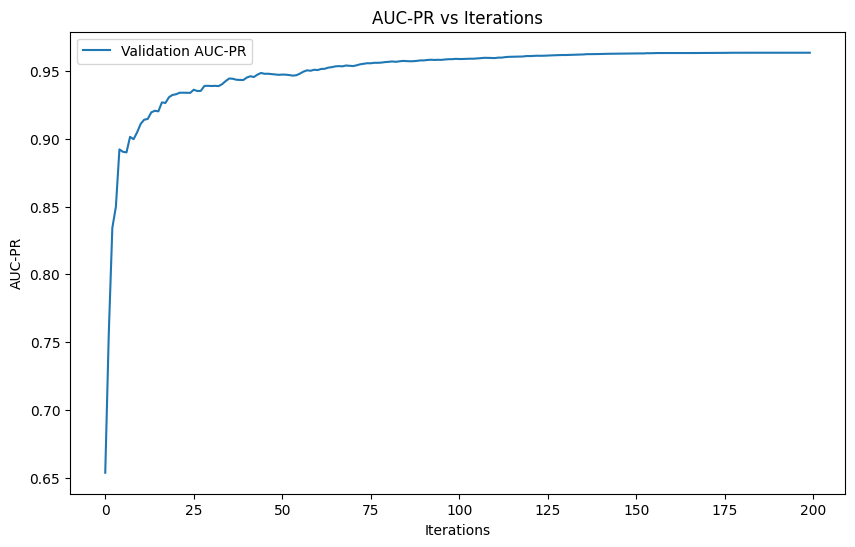

In [128]:
val_aucpr = metrics["validation_0"]["aucpr"]

plt.figure(figsize=(10,6))

plt.plot(val_aucpr, label="Validation AUC-PR")
plt.xlabel("Iterations")
plt.ylabel("AUC-PR")
plt.title("AUC-PR vs Iterations")
plt.legend()


In [129]:
precisions, recalls, thresholds = precision_recall_curve(y_test.to_list(), y_probs)

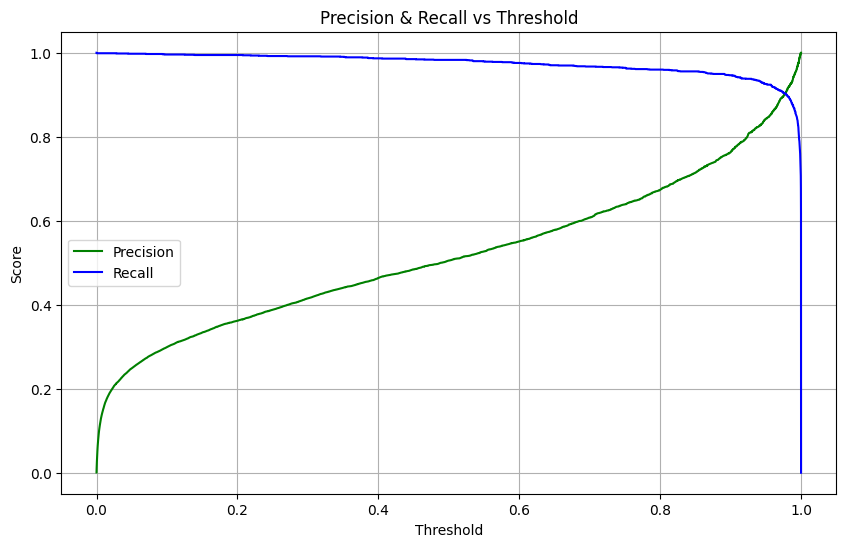

In [130]:
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions[:-1], label='Precision', color='green')
plt.plot(thresholds, recalls[:-1], label='Recall', color='blue')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

In [131]:
feature_names

array(['numerical_vars__step', 'numerical_vars__amount',
       'numerical_vars__oldbalanceOrg', 'numerical_vars__newbalanceOrig',
       'numerical_vars__oldbalanceDest', 'numerical_vars__newbalanceDest',
       'categorical_vars_type__type_CASH_OUT',
       'categorical_vars_type__type_TRANSFER',
       'categorical_vars_type__type_other',
       'categorical_vars_dest_group__dest_group'], dtype=object)

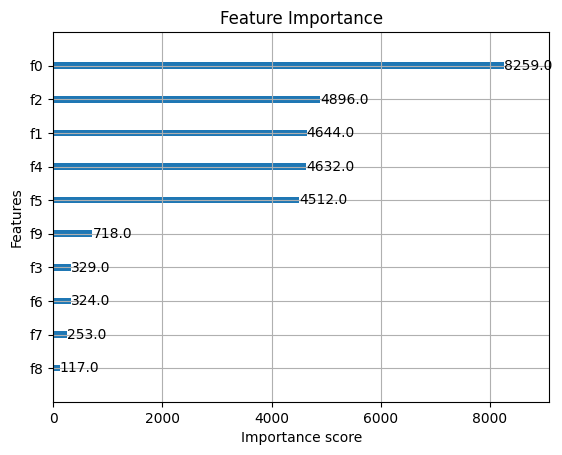

In [132]:
xgb.plot_importance(model, max_num_features=20)
plt.title("Feature Importance")
plt.show()